In [3]:
from pyspark.sql import SparkSession
import os
import tempfile
import urllib.request

# Create Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("log-reg") \
    .getOrCreate()

# Correct raw GitHub URL and safe local path (no leading slash in filename)
url = "https://raw.githubusercontent.com/Apress/machine-learning-with-pyspark/master/chapter_5_Logistic_Regression/Log_Reg_dataset.csv"
local_path = os.path.join(tempfile.gettempdir(), "Log_Reg_dataset.csv")

# Download dataset (overwrites if already present)
urllib.request.urlretrieve(url, local_path)

# Read with Spark
df = spark.read.csv(local_path, header=True, inferSchema=True)

# Quick sanity check
print(f"Loaded file: {local_path} (exists={os.path.exists(local_path)})")
df.show(5)

Loaded file: /tmp/Log_Reg_dataset.csv (exists=True)
+---------+---+--------------+--------+----------------+------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|
+---------+---+--------------+--------+----------------+------+
|    India| 41|             1|   Yahoo|              21|     1|
|   Brazil| 28|             1|   Yahoo|               5|     0|
|   Brazil| 40|             0|  Google|               3|     0|
|Indonesia| 31|             1|    Bing|              15|     1|
| Malaysia| 32|             0|  Google|              15|     1|
+---------+---+--------------+--------+----------------+------+
only showing top 5 rows


# Exploratory analysis

In [4]:
df.count(), len(df.columns), df.columns

(20000,
 6,
 ['Country',
  'Age',
  'Repeat_Visitor',
  'Platform',
  'Web_pages_viewed',
  'Status'])

In [5]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)



In [7]:
df.describe().show()

+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|summary| Country|              Age|   Repeat_Visitor|Platform| Web_pages_viewed|            Status|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|  count|   20000|            20000|            20000|   20000|            20000|             20000|
|   mean|    NULL|         28.53955|           0.5029|    NULL|           9.5533|               0.5|
| stddev|    NULL|7.888912950773227|0.500004090187782|    NULL|6.073903499824976|0.5000125004687693|
|    min|  Brazil|               17|                0|    Bing|                1|                 0|
|    max|Malaysia|              111|                1|   Yahoo|               29|                 1|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+



In [8]:
df.groupBy("Country").count().show()

+---------+-----+
|  Country|count|
+---------+-----+
| Malaysia| 1218|
|    India| 4018|
|Indonesia|12178|
|   Brazil| 2586|
+---------+-----+



In [11]:
df.groupBy("Platform").count().show()

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|    Bing| 4360|
|  Google| 5781|
+--------+-----+



In [12]:
df.groupBy("Status").count().show()

+------+-----+
|Status|count|
+------+-----+
|     1|10000|
|     0|10000|
+------+-----+



In [13]:
df.groupBy('Country').mean().show()

+---------+------------------+-------------------+---------------------+--------------------+
|  Country|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|         avg(Status)|
+---------+------------------+-------------------+---------------------+--------------------+
| Malaysia|27.792282430213465| 0.5730706075533661|   11.192118226600986|  0.6568144499178982|
|    India|27.976854156296664| 0.5433051269288203|   10.727227476356397|  0.6212045793927327|
|Indonesia| 28.43159796354081| 0.5207751683363442|    9.985711939563148|  0.5422893742814913|
|   Brazil|30.274168600154677|  0.322892498066512|    4.921113689095128|0.038669760247486466|
+---------+------------------+-------------------+---------------------+--------------------+



In [14]:
df.groupBy('Status').mean().show()

+------+--------+-------------------+---------------------+-----------+
|Status|avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|avg(Status)|
+------+--------+-------------------+---------------------+-----------+
|     1| 26.5435|             0.7019|              14.5617|        1.0|
|     0| 30.5356|             0.3039|               4.5449|        0.0|
+------+--------+-------------------+---------------------+-----------+



# Feature engineering

In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [18]:
search_engine_indexer = StringIndexer(inputCol="Platform", outputCol="Search_Engine_Num").fit(df)
df = search_engine_indexer.transform(df)
df.show(5)

+---------+---+--------------+--------+----------------+------+-----------------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Search_Engine_Num|
+---------+---+--------------+--------+----------------+------+-----------------+
|    India| 41|             1|   Yahoo|              21|     1|              0.0|
|   Brazil| 28|             1|   Yahoo|               5|     0|              0.0|
|   Brazil| 40|             0|  Google|               3|     0|              1.0|
|Indonesia| 31|             1|    Bing|              15|     1|              2.0|
| Malaysia| 32|             0|  Google|              15|     1|              1.0|
+---------+---+--------------+--------+----------------+------+-----------------+
only showing top 5 rows


In [19]:
df.groupBy('Platform').count().orderBy('count', ascending=False).show(5)

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|  Google| 5781|
|    Bing| 4360|
+--------+-----+



In [20]:
df.groupBy('Search_Engine_Num').count().orderBy('count', ascending=False).show(5)

+-----------------+-----+
|Search_Engine_Num|count|
+-----------------+-----+
|              0.0| 9859|
|              1.0| 5781|
|              2.0| 4360|
+-----------------+-----+



In [22]:
search_engine_encoder = OneHotEncoder(inputCol="Search_Engine_Num", outputCol="Search_Engine_Vector")

df = search_engine_encoder.fit(df).transform(df)

df.show(5)

+---------+---+--------------+--------+----------------+------+-----------------+--------------------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Search_Engine_Num|Search_Engine_Vector|
+---------+---+--------------+--------+----------------+------+-----------------+--------------------+
|    India| 41|             1|   Yahoo|              21|     1|              0.0|       (2,[0],[1.0])|
|   Brazil| 28|             1|   Yahoo|               5|     0|              0.0|       (2,[0],[1.0])|
|   Brazil| 40|             0|  Google|               3|     0|              1.0|       (2,[1],[1.0])|
|Indonesia| 31|             1|    Bing|              15|     1|              2.0|           (2,[],[])|
| Malaysia| 32|             0|  Google|              15|     1|              1.0|       (2,[1],[1.0])|
+---------+---+--------------+--------+----------------+------+-----------------+--------------------+
only showing top 5 rows


In [23]:
df.groupBy('Search_Engine_Vector').count().orderBy('count', ascending=False).show(5)

+--------------------+-----+
|Search_Engine_Vector|count|
+--------------------+-----+
|       (2,[0],[1.0])| 9859|
|       (2,[1],[1.0])| 5781|
|           (2,[],[])| 4360|
+--------------------+-----+



In [24]:
country_indexer = StringIndexer(inputCol="Country", outputCol="Country_Num").fit(df)
df = country_indexer.transform(df)
df.groupBy('Country_Num').count().orderBy('count', ascending=False).show(5)

+-----------+-----+
|Country_Num|count|
+-----------+-----+
|        0.0|12178|
|        1.0| 4018|
|        2.0| 2586|
|        3.0| 1218|
+-----------+-----+



In [25]:
country_encoder = OneHotEncoder(inputCol="Country_Num", outputCol="Country_Vector")
df = country_encoder.fit(df).transform(df)
df.select(["Country", "Country_Num", "Country_Vector"]).show(5)

+---------+-----------+--------------+
|  Country|Country_Num|Country_Vector|
+---------+-----------+--------------+
|    India|        1.0| (3,[1],[1.0])|
|   Brazil|        2.0| (3,[2],[1.0])|
|   Brazil|        2.0| (3,[2],[1.0])|
|Indonesia|        0.0| (3,[0],[1.0])|
| Malaysia|        3.0|     (3,[],[])|
+---------+-----------+--------------+
only showing top 5 rows


In [26]:
df_assembler = VectorAssembler(
    inputCols=["Search_Engine_Vector", "Country_Vector",
               "Age", "Repeat_Visitor", "Web_pages_viewed"],
    outputCol="features")
df = df_assembler.transform(df)

df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Search_Engine_Num: double (nullable = false)
 |-- Search_Engine_Vector: vector (nullable = true)
 |-- Country_Num: double (nullable = false)
 |-- Country_Vector: vector (nullable = true)
 |-- features: vector (nullable = true)



In [29]:
df.select(["features", "Status"]).show(10, truncate=False)

+-----------------------------------+------+
|features                           |Status|
+-----------------------------------+------+
|[1.0,0.0,0.0,1.0,0.0,41.0,1.0,21.0]|1     |
|[1.0,0.0,0.0,0.0,1.0,28.0,1.0,5.0] |0     |
|(8,[1,4,5,7],[1.0,1.0,40.0,3.0])   |0     |
|(8,[2,5,6,7],[1.0,31.0,1.0,15.0])  |1     |
|(8,[1,5,7],[1.0,32.0,15.0])        |1     |
|(8,[1,4,5,7],[1.0,1.0,32.0,3.0])   |0     |
|(8,[1,4,5,7],[1.0,1.0,32.0,6.0])   |0     |
|(8,[1,2,5,7],[1.0,1.0,27.0,9.0])   |0     |
|(8,[0,2,5,7],[1.0,1.0,32.0,2.0])   |0     |
|(8,[2,5,6,7],[1.0,31.0,1.0,16.0])  |1     |
+-----------------------------------+------+
only showing top 10 rows


In [30]:
model_data = df.select(["features", "Status"])

# Splitting the data into training and test sets

In [32]:
training_df, test_df = model_data.randomSplit([0.75, 0.25], seed=42)
training_df.count(), test_df.count()

(15021, 4979)

In [34]:
training_df.groupBy('Status').count().show()
test_df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 7562|
|     0| 7459|
+------+-----+

+------+-----+
|Status|count|
+------+-----+
|     1| 2438|
|     0| 2541|
+------+-----+



# Building and Training Logistic Regresion Model

In [35]:
from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(labelCol="Status").fit(training_df)

In [36]:
train_results = log_reg.evaluate(training_df).predictions

In [37]:
train_results.filter(train_results["Status"] == 1).filter(train_results['prediction'] == 1).select(['Status', 'prediction','probability']).show(5, truncate=False)

+------+----------+----------------------------------------+
|Status|prediction|probability                             |
+------+----------+----------------------------------------+
|1     |1.0       |[0.29225242902572685,0.7077475709742731]|
|1     |1.0       |[0.16202960483917334,0.8379703951608266]|
|1     |1.0       |[0.16202960483917334,0.8379703951608266]|
|1     |1.0       |[0.16202960483917334,0.8379703951608266]|
|1     |1.0       |[0.0830250462205416,0.9169749537794584] |
+------+----------+----------------------------------------+
only showing top 5 rows


In [38]:
test_results = log_reg.evaluate(test_df).predictions

test_results.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Status: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [49]:
test_results.show(5, truncate=False)

+--------------------------------+------+--------------------------------------+------------------------------------------+----------+
|features                        |Status|rawPrediction                         |probability                               |prediction|
+--------------------------------+------+--------------------------------------+------------------------------------------+----------+
|(8,[0,2,5,7],[1.0,1.0,17.0,1.0])|0     |[5.944137565233802,-5.944137565233802]|[0.9973856905733685,0.0026143094266315448]|0.0       |
|(8,[0,2,5,7],[1.0,1.0,17.0,1.0])|0     |[5.944137565233802,-5.944137565233802]|[0.9973856905733685,0.0026143094266315448]|0.0       |
|(8,[0,2,5,7],[1.0,1.0,17.0,2.0])|0     |[5.185403437967377,-5.185403437967377]|[0.9944334817320457,0.00556651826795429]  |0.0       |
|(8,[0,2,5,7],[1.0,1.0,17.0,2.0])|0     |[5.185403437967377,-5.185403437967377]|[0.9944334817320457,0.00556651826795429]  |0.0       |
|(8,[0,2,5,7],[1.0,1.0,17.0,2.0])|0     |[5.18540343796

# Evaluation of the Model

In [40]:
tp = test_results.filter(test_results["Status"] == 1).filter(test_results['prediction'] == 1).count()
tn = test_results.filter(test_results["Status"] == 0).filter(test_results['prediction'] == 0).count()
fp = test_results.filter(test_results["Status"] == 0).filter(test_results['prediction'] == 1).count()
fn = test_results.filter(test_results["Status"] == 1).filter(test_results['prediction'] == 0).count()

In [42]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

0.9353283791926089

In [43]:
recall = tp / (tp + fn)
recall

0.9397046759639048

In [44]:
precision = tp / (tp + fp)
precision

0.9290348742903487

<Axes: >

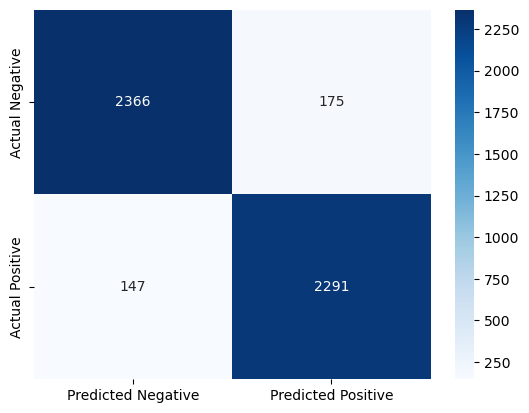

In [45]:
import seaborn as sns
cm = [[tn, fp],
      [fn, tp]]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

In [53]:
# ROC Curve and AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Status", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(test_results)
auc

0.9848660798023168

In [54]:
# ROC Curve and AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Status")
auc = evaluator.evaluate(test_results)
auc

0.9848660798023168

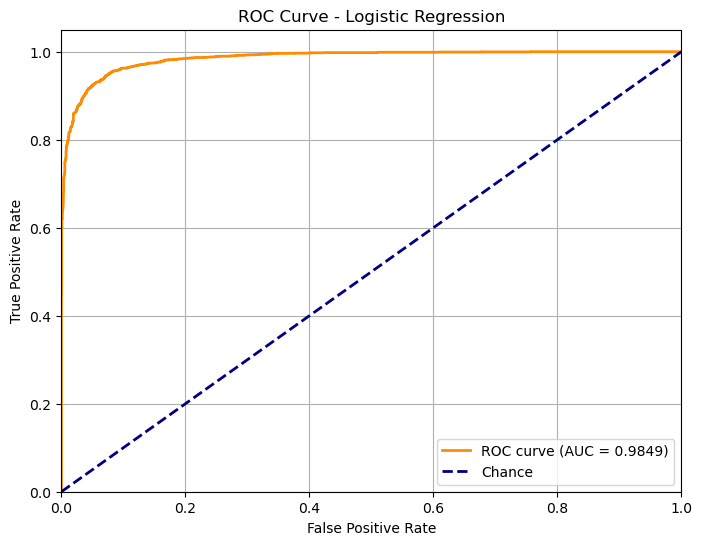

In [48]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# extract probability for the positive class and labels from the Spark DataFrame
rows = test_results.select("probability", "Status").rdd.map(lambda r: (float(r['probability'][1]), int(r['Status']))).collect()
pdf = pd.DataFrame(rows, columns=["prob", "label"])

# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(pdf["label"], pdf["prob"])
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()